In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    GlobalAveragePooling2D, Reshape, MultiHeadAttention,
    Add, Activation, Concatenate, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# dataset directory
dataset_dir = "../real-dataset/compiled/"

# load and preprocess the dataset without batching
data = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=None,  # ← KEY CHANGE: No batching yet
    shuffle=True,
    seed=42  # For reproducibility
)

Found 545 files belonging to 5 classes.


In [3]:
# split the dataset into train, validation, and test sets
def split_dataset(dataset, train_size=0.7, val_size=0.2, batch_size=32):
    total_size = dataset.cardinality().numpy()

    train_count = int(total_size * train_size)
    val_count = int(total_size * val_size)
    test_count = total_size - train_count - val_count

    # Split BEFORE batching
    train_dataset = dataset.take(train_count).batch(batch_size)
    val_test_dataset = dataset.skip(train_count)
    val_dataset = val_test_dataset.take(val_count).batch(batch_size)
    test_dataset = val_test_dataset.skip(val_count).batch(batch_size)

    print(f"Dataset split finished: {train_count} train, {val_count} val, {test_count} test samples.")
    return train_dataset, val_dataset, test_dataset

train, val, test = split_dataset(data, batch_size=32)

# Prefetch for performance
train = train.prefetch(tf.data.AUTOTUNE)
val = val.prefetch(tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)

Dataset split finished: 381 train, 109 val, 55 test samples.


In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Collect all labels from the training set
train_labels = []
for _, labels in train.unbatch():  # unbatch to get single samples
    train_labels.append(labels.numpy())

train_labels = np.array(train_labels)
print(f"Collected {len(train_labels)} training labels.")

# Compute class weights
classes = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weight_dict = dict(zip(classes, class_weights))

# Debug output
print("class weights calculation:")
for cls, weight in class_weight_dict.items():
    print(f"  Class {cls}: {weight:.4f}")

Collected 381 training labels.
class weights calculation:
  Class 0: 0.7776
  Class 1: 0.6927
  Class 2: 1.7318
  Class 3: 2.0595
  Class 4: 0.8283


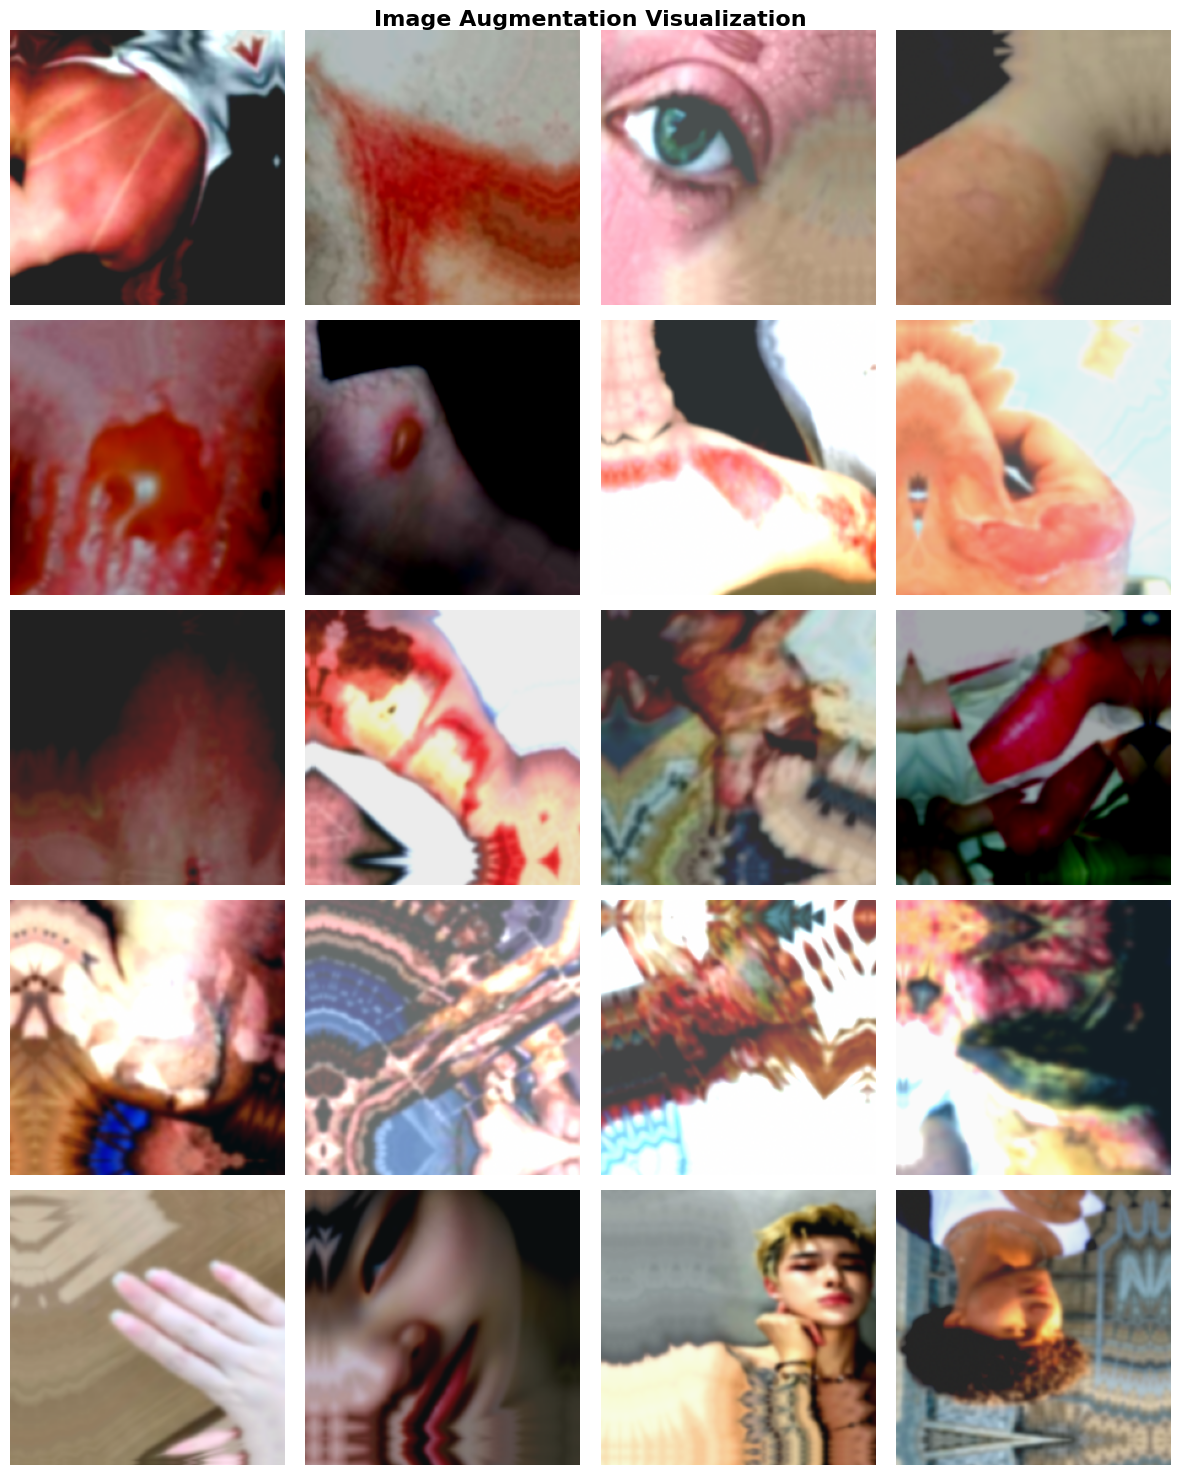

In [11]:
# Advanced augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.GaussianNoise(0.01),
], name='data_augmentation')

# Apply augmentation with training=True
train = train.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

# Define class labels
class_labels = {
    0: 'First Degree',
    1: 'Second Degree',
    2: 'Third Degree',
    3: 'Fourth Degree',
    4: 'Normal Skin'
}

import random

# Visualize 4 random augmented images per category
num_per_class = 4
samples = {k: [] for k in class_labels.keys()}

for images, labels in train.unbatch():
    label = int(labels.numpy())
    if len(samples[label]) < num_per_class:
        samples[label].append(images)
    # Stop when all classes have enough samples
    if all(len(v) == num_per_class for v in samples.values()):
        break

plt.figure(figsize=(num_per_class * 3, len(class_labels) * 3))
for class_idx, (cat, imgs) in enumerate(samples.items()):
    for i, img in enumerate(imgs):
        ax = plt.subplot(len(class_labels), num_per_class, class_idx * num_per_class + i + 1)
        img = tf.clip_by_value(img, 0, 255)
        plt.imshow(img.numpy().astype("uint8"))
        if i == 0:
            ax.set_ylabel(class_labels[cat], fontsize=12, fontweight='bold')
        plt.axis("off")
plt.suptitle("Image Augmentation Visualization", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, Add, Input, Reshape, GlobalAveragePooling1D)
from tensorflow.keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Attention block
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed-forward block
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

def build_hybrid_model(input_shape=(224, 224, 3), num_classes=5):
    inputs = Input(shape=input_shape)

    # CNN Backbone (feature extractor)
    base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs, name="resnet50")
    base_model.trainable = False   # fine-tune later if needed

    x = base_model.output  # shape: (7, 7, 2048)
    x = Reshape((49, 2048))(x)  # Flatten spatial grid into sequence

    # Transformer blocks
    for _ in range(2):  # can increase for more power
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)

    # Pool transformer outputs
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# Usage
model = build_hybrid_model(num_classes=5)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 29,916,037 (114.12 MB)

 Trainable params: 6,328,325 (24.14 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [17]:
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2861 - loss: 2.1295 - val_accuracy: 0.4587 - val_loss: 1.2450 - learning_rate: 1.0000e-04
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4436 - loss: 1.4932 - val_accuracy: 0.6789 - val_loss: 0.8220 - learning_rate: 1.0000e-04
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5748 - loss: 1.1400 - val_accuracy: 0.7706 - val_loss: 0.5350 - learning_rate: 1.0000e-04
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6535 - loss: 0.9130 - val_accuracy: 0.6972 - val_loss: 0.7641 - learning_rate: 1.0000e-04
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6719 - loss: 0.8825 - val_accuracy: 0.7615 - val_loss: 0.6870 - learning_rate: 1.0000e-04
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7664 - loss: 0.7109 - val_accuracy: 0.8165 - val_loss: 0.4767 - learning_rate: 1.0000e-04
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7480 - loss:

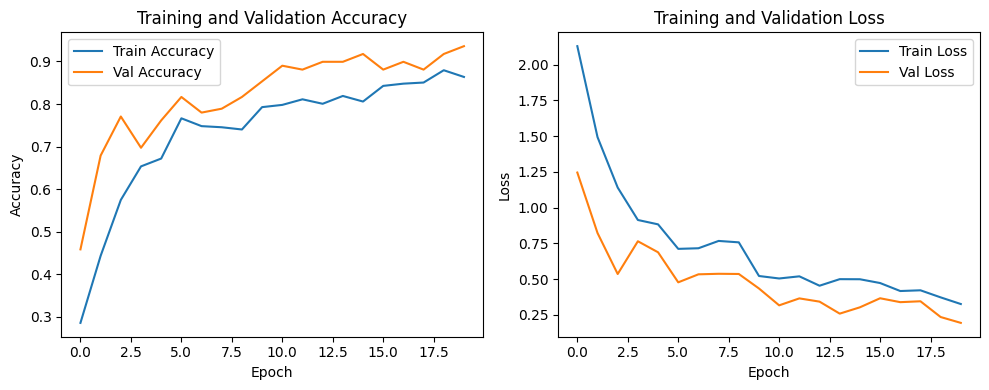

In [18]:
import matplotlib.pyplot as plt

# Plot accuracy and loss after training
plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
model.save('../real-checkpoints/model_vanilla.h5')

In [22]:
# Stage 2: Unfreeze top ResNet layers (last 30 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7402 - loss: 0.7255 - val_accuracy: 0.8716 - val_loss: 0.3557 - learning_rate: 1.0000e-05
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8005 - loss: 0.4763 - val_accuracy: 0.8807 - val_loss: 0.3359 - learning_rate: 1.0000e-05
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8005 - loss: 0.4661 - val_accuracy: 0.8073 - val_loss: 0.4474 - learning_rate: 1.0000e-05
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8163 - loss: 0.4960 - val_accuracy: 0.8807 - val_loss: 0.3300 - learning_rate: 5.0000e-06
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8346 - loss: 0.4238 - val_accuracy: 0.9174 - val_loss: 0.2646 - learning_rate: 5.0000e-06


In [23]:
model.save('../real-checkpoints/finetunes1.h5')

In [24]:
# Stage 2: Unfreeze top ResNet layers (last 60 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-60:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.7979 - loss: 0.5429 - val_accuracy: 0.8899 - val_loss: 0.3270 - learning_rate: 2.0000e-05
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8163 - loss: 0.4880 - val_accuracy: 0.8899 - val_loss: 0.2115 - learning_rate: 2.0000e-05
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8346 - loss: 0.3853 - val_accuracy: 0.8899 - val_loss: 0.3036 - learning_rate: 2.0000e-05
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8320 - loss: 0.3583 - val_accuracy: 0.8716 - val_loss: 0.3263 - learning_rate: 1.0000e-05
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8530 - loss: 0.3345 - val_accuracy: 0.9083 - val_loss: 0.2538 - learning_rate: 1.0000e-05


In [25]:
model.save('../real-checkpoints/finetunes2.h5')

In [26]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

# Evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Test Precision: {pre.result().numpy():.4f}")
print(f"Test Recall: {re.result().numpy():.4f}")
print(f"Test Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Test Precision: 1.0000
Test Recall: 0.9091
Test Accuracy: 0.9091


In [27]:
#Unfreeze top ResNet layers (last 90 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-90:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.7743 - loss: 0.5336 - val_accuracy: 0.8532 - val_loss: 0.3837 - learning_rate: 2.0000e-05
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.7979 - loss: 0.4614 - val_accuracy: 0.9083 - val_loss: 0.1839 - learning_rate: 2.0000e-05
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8215 - loss: 0.3952 - val_accuracy: 0.8991 - val_loss: 0.3250 - learning_rate: 2.0000e-05
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8504 - loss: 0.3343 - val_accuracy: 0.9541 - val_loss: 0.1671 - learning_rate: 2.0000e-05
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8688 - loss: 0.3195 - val_accuracy: 0.9358 - val_loss: 0.2393 - learning_rate: 2.0000e-05
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8425 - loss: 0.3839 - val_accuracy: 0.9450 - val_loss: 0.1878 - learning_rate: 2.0000e-05
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8740 - loss:

In [29]:
model.save('../real-checkpoints/finetunes3.h5')

In [30]:
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-150:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.8268 - loss: 0.4435 - val_accuracy: 0.9266 - val_loss: 0.2458 - learning_rate: 2.0000e-05
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - accuracy: 0.8556 - loss: 0.3844 - val_accuracy: 0.8991 - val_loss: 0.2668 - learning_rate: 2.0000e-05
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.8451 - loss: 0.3227 - val_accuracy: 0.9266 - val_loss: 0.2853 - learning_rate: 2.0000e-05
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.8766 - loss: 0.2647 - val_accuracy: 0.9358 - val_loss: 0.2305 - learning_rate: 1.0000e-05
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.8583 - loss: 0.2978 - val_accuracy: 0.9174 - val_loss: 0.2961 - learning_rate: 1.0000e-05


In [31]:
pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 0.9756
Recall: 0.9524
Accuracy: 0.8909


In [32]:
model.save('../real-checkpoints/finetunes4.h5')

In [33]:
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-200:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - accuracy: 0.8635 - loss: 0.4080 - val_accuracy: 0.8807 - val_loss: 0.2895 - learning_rate: 1.0000e-06
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.8373 - loss: 0.3937 - val_accuracy: 0.9083 - val_loss: 0.2754 - learning_rate: 1.0000e-06
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.8373 - loss: 0.4255 - val_accuracy: 0.9174 - val_loss: 0.2193 - learning_rate: 1.0000e-06
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - accuracy: 0.8268 - loss: 0.4431 - val_accuracy: 0.9174 - val_loss: 0.2852 - learning_rate: 1.0000e-06
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - accuracy: 0.8583 - loss: 0.3821 - val_accuracy: 0.8991 - val_loss: 0.2412 - learning_rate: 1.0000e-06


In [34]:
model.save('../real-checkpoints/finetunes5.h5')

In [35]:
from tensorflow.keras.models import load_model

# Load the the best model
model = load_model('../real-checkpoints/finetunes3.h5')

pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 1.0000
Recall: 0.9500
Accuracy: 0.9455


In [36]:
# Load the the best model
model = load_model('../real-checkpoints/finetunes3.h5')

for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False
# Unfreeze transformer layers (those after ResNet output)
for layer in model.layers:
    if 'multi_head_attention' in layer.name or 'dense' in layer.name or 'dropout' in layer.name or 'layer_normalization' in layer.name:
        layer.trainable = True

# Recompile with a low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune transformer layers
history_transformer = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8766 - loss: 0.3685 - val_accuracy: 0.8899 - val_loss: 0.3200 - learning_rate: 1.0000e-05
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9160 - loss: 0.2467 - val_accuracy: 0.9266 - val_loss: 0.2305 - learning_rate: 1.0000e-05
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8688 - loss: 0.3461 - val_accuracy: 0.9266 - val_loss: 0.1513 - learning_rate: 1.0000e-05
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9186 - loss: 0.2025 - val_accuracy: 0.9266 - val_loss: 0.2421 - learning_rate: 1.0000e-05
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9029 - loss: 0.2497 - val_accuracy: 0.8991 - val_loss: 0.2157 - learning_rate: 1.0000e-05
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9029 - loss: 0.2410 - val_accuracy: 0.9358 - val_loss: 0.2148 - learning_rate: 1.0000e-05
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9081 - loss:

In [37]:
pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 1.0000
Recall: 0.9535
Accuracy: 0.9636


In [38]:
model.save('../real-checkpoints/finalfinetuning.h5')

In [ ]:
# Load the the best model
model = load_model('../real-checkpoints/finetunes3.h5')